In [1]:
import numpy as np
# !pip install cartopy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
dataset = np.load('ERA_wind.npz')

# prints the file names in the dataset
# print(dataset.files)

In [11]:
lat = dataset.get('lat')  
lon = dataset.get('lon')  
x_grid, y_grid = np.meshgrid(lon, lat, indexing='xy')
x_values = x_grid.flatten()
y_values = y_grid.flatten()

[-60.   -59.75 -59.5  -59.25 -59.   -58.75 -58.5  -58.25 -58.   -57.75
 -57.5  -57.25 -57.   -56.75 -56.5  -56.25 -56.   -55.75 -55.5  -55.25
 -55.   -54.75 -54.5  -54.25 -54.   -53.75 -53.5  -53.25 -53.   -52.75
 -52.5  -52.25 -52.   -51.75 -51.5  -51.25 -51.   -50.75 -50.5  -50.25
 -50.   -49.75 -49.5  -49.25 -49.   -48.75 -48.5  -48.25 -48.   -47.75
 -47.5  -47.25 -47.   -46.75 -46.5  -46.25 -46.   -45.75 -45.5  -45.25
 -45.   -44.75 -44.5  -44.25 -44.   -43.75 -43.5  -43.25 -43.   -42.75
 -42.5  -42.25 -42.   -41.75 -41.5  -41.25 -41.   -40.75 -40.5  -40.25
 -40.   -39.75 -39.5  -39.25 -39.   -38.75 -38.5  -38.25 -38.   -37.75
 -37.5  -37.25 -37.   -36.75 -36.5  -36.25 -36.   -35.75 -35.5  -35.25
 -35.   -34.75 -34.5  -34.25 -34.   -33.75 -33.5  -33.25 -33.   -32.75
 -32.5  -32.25 -32.   -31.75 -31.5  -31.25 -31.   -30.75 -30.5  -30.25
 -30.   -29.75 -29.5  -29.25 -29.   -28.75 -28.5  -28.25 -28.   -27.75
 -27.5  -27.25 -27.   -26.75 -26.5  -26.25 -26.   -25.75 -25.5  -25.25
 -25. 

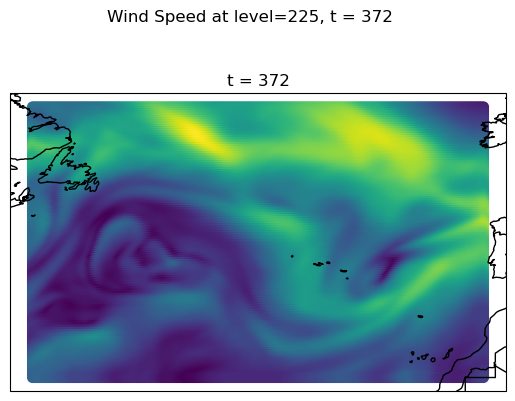

In [4]:
# 744 is the number of timestamps.
# In dataset.get('wind_u')[int(744*r/4)][1], [1] is the level 225.

fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Wind Speed at level=225, t = {}'.format(int(744*2/4)))

r = 2
u = dataset.get('wind_u')[int(744*r/4)][1]
v = dataset.get('wind_v')[int(744*r/4)][1]
wind_speed = np.sqrt(u**2 + v**2)
wind_speed_flat = wind_speed.flatten()

scatter_plot = axs.scatter(x_values, y_values, c=wind_speed_flat, cmap='viridis', s=50, transform=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.BORDERS)
axs.set_title("t = {}".format(int(744*r/4)))

plt.show()

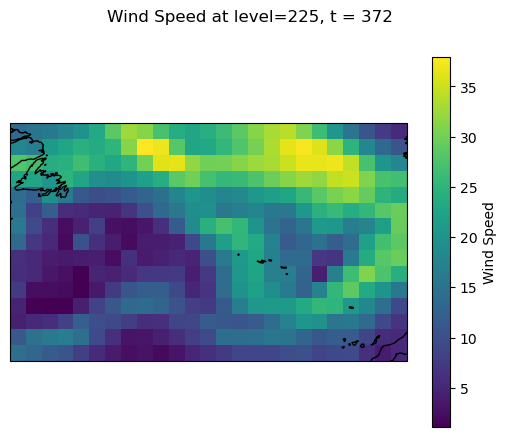

In [25]:
# GPT CODE: Method 1
# Reducing the number of latitude and longitude points by selecting every k-th point from the lat and lon arrays

# Coarsening factor k
k = 8  # For example, choose every second point

# Original data retrieval
lat = dataset.get('lat')
lon = dataset.get('lon')

# Coarsen the resolution by selecting every k-th point
lat_coarse = lat[::k]
lon_coarse = lon[::k]

# Generate the coarsened grid
x_grid_coarse, y_grid_coarse = np.meshgrid(lon_coarse, lat_coarse, indexing='xy')
x_values_coarse = x_grid_coarse.flatten()
y_values_coarse = y_grid_coarse.flatten()

# Assuming the rest of your setup is unchanged
fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Wind Speed at level=225, t = {}'.format(int(744*2/4)))

r = 2
# Retrieve and coarsen wind components
u = dataset.get('wind_u')[int(744*r/4)][1][::k, ::k]  # Coarsen data
v = dataset.get('wind_v')[int(744*r/4)][1][::k, ::k]  # Coarsen data
wind_speed = np.sqrt(u**2 + v**2)
wind_speed_flat = wind_speed.flatten()

mesh_plot = axs.pcolormesh(x_grid_coarse, y_grid_coarse, wind_speed_coarse, cmap='viridis', transform=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.BORDERS)
plt.colorbar(mesh_plot, ax=axs, orientation='vertical', label='Wind Speed')

plt.show()

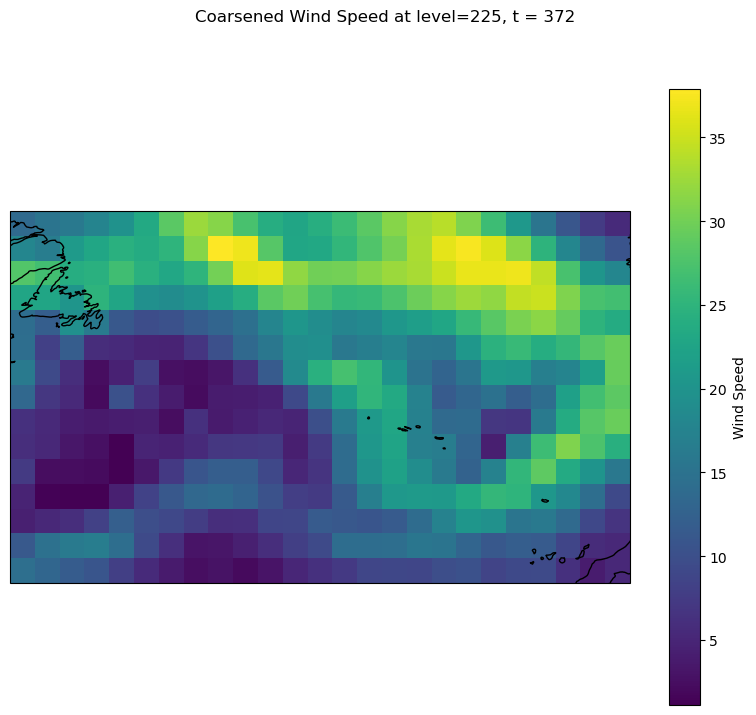

In [24]:
# GPT Code: Method 2
# Spatial Gridbox Averaging; check if correct.
# Takes the mean of the latitudes and longitudes in each block to determine the "center" of the block

import numpy as np

def coarsen_with_averaging(data, k):
    """
    Coarsen data by averaging over kxk blocks.
    Assumes data is a 2D array.
    """
    nrows, ncols = data.shape
    nrows_coarse = nrows // k
    ncols_coarse = ncols // k
    data_coarse = np.zeros((nrows_coarse, ncols_coarse))
    for i in range(nrows_coarse):
        for j in range(ncols_coarse):
            data_block = data[i*k:(i+1)*k, j*k:(j+1)*k]
            data_coarse[i, j] = np.mean(data_block)
    return data_coarse

# Applying the coarsening function to the wind components
k = 8  # Example coarsening factor
u_coarse = coarsen_with_averaging(dataset.get('wind_u')[int(744*2/4)][1], k)
v_coarse = coarsen_with_averaging(dataset.get('wind_v')[int(744*2/4)][1], k)
wind_speed_coarse = np.sqrt(u_coarse**2 + v_coarse**2)

def average_blocks(arr, k):
    """Averages non-overlapping kxk blocks of arr."""
    end = k * (len(arr) // k)
    return arr[:end].reshape(-1, k).mean(axis=1)

lat_coarse = average_blocks(lat, k)
lon_coarse = average_blocks(lon, k)
x_grid_coarse, y_grid_coarse = np.meshgrid(lon_coarse, lat_coarse, indexing='xy')

# Create a figure with cartopy
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Coarsened Wind Speed at level=225, t = {}'.format(int(744*2/4)))

# Flatten the coarsened grid for plotting
x_values_coarse = x_grid_coarse.flatten()
y_values_coarse = y_grid_coarse.flatten()
wind_speed_flat_coarse = wind_speed_coarse.flatten()

# Ensure all coarsened arrays are consistent in size before plotting
assert len(x_grid_coarse.flatten()) == len(y_grid_coarse.flatten()) == len(wind_speed_coarse.flatten()), "Array sizes must match for plotting."

# # Now, use the corrected arrays for plotting
# scatter_plot = axs.scatter(x_grid_coarse.flatten(), y_grid_coarse.flatten(), c=wind_speed_coarse.flatten(), cmap='viridis', s=250, transform=ccrs.PlateCarree())
# axs.coastlines()
# axs.add_feature(cfeature.BORDERS)
# axs.set_title("Coarsened Wind Speed at t = {}".format(int(744*r/4)))

# # Adding a color bar
# plt.colorbar(scatter_plot, ax=axs, orientation='vertical', label='Wind Speed')

mesh_plot = axs.pcolormesh(x_grid_coarse, y_grid_coarse, wind_speed_coarse, cmap='viridis', transform=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.BORDERS)
plt.colorbar(mesh_plot, ax=axs, orientation='vertical', label='Wind Speed')

plt.show()